In [1]:
import sys
sys.path.insert(1, '..')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from conn.conn_tf import _tf_decomp
from conn.conn_spec import conn_spec

In [2]:
class TestConnSpec:

    n_roi, n_times, n_epochs = 4, 1000, 20
    n_edges = int(n_roi*(n_roi-1)/2)
    sfreq, freqs = 200, np.arange(1, 51, 1)
    n_freqs = len(freqs)
    n_cycles = freqs/2
    times = np.arange(0, n_times//sfreq, 1/sfreq)
    eta = np.random.normal(0, 1, size=(n_epochs, n_roi, n_times))

    def test_tf_decomp(self, ):
        
        # Test output shape
        for mode in ["morlet", "multitaper"]:
            out = _tf_decomp(self.eta, self.sfreq, self.freqs, mode=mode,
                             n_cycles=self.n_cycles, n_jobs=1)
            self.__assert_shape(out.shape, conn=False)
            
        # For multitaper test both single and array mt_bandwidth
        out1 = _tf_decomp(self.eta, self.sfreq, self.freqs, mode="multitaper",
             n_cycles=self.n_cycles, mt_bandwidth=4, n_jobs=1)
        out2 = _tf_decomp(self.eta, self.sfreq, self.freqs, mode="multitaper",
             n_cycles=self.n_cycles, mt_bandwidth=[4]*self.n_freqs, n_jobs=1)
        np.testing.assert_array_equal(out1, out2)
        
        ##################################################################
        # Compare the auto-spectra with groundtruth
        ##################################################################
        for mode in ["morlet", "multitaper"]:
            
            # 1. Compare for stationary sinal
            x = self.__get_signal(stationary=True)
            
            out = _tf_decomp(x, self.sfreq, self.freqs, mode=mode,
                             n_cycles=self.n_cycles, n_jobs=1)
            out = (out*np.conj(out)).real
            
            if mode == "morlet":
                val, atol = 20, 2
            else:
                val, atol = 5.8, 0.3
            actual = out.mean(axis=(0,-1))[:, self.__get_freqs_indexes(28, 32)].mean(1)
            np.testing.assert_allclose(actual, val*np.ones_like(actual), atol=atol)
            
            # 2. Compare for non-stationary signal
            x = self.__get_signal(stationary=False)
            
            out = _tf_decomp(x, self.sfreq, self.freqs, mode=mode,
                             n_cycles=self.n_cycles, n_jobs=1)
            out = (out*np.conj(out)).real
            
            if mode == "morlet":
                val, atol = 11, 1
            else:
                val, atol = 3.2, 0.3
            actual1 = out.mean(axis=(0,-1))[:, self.__get_freqs_indexes(8, 12)].mean(1)
            actual2 = out.mean(axis=(0,-1))[:, self.__get_freqs_indexes(28, 32)].mean(1)
            np.testing.assert_allclose(actual1, val*np.ones_like(actual), atol=atol)            
            np.testing.assert_allclose(actual2, val*np.ones_like(actual), atol=atol)

    def test_conn_spec(self,):
        """Test function conn_spec"""
        
        # General parameters for the conn_spec function
        kw = dict(sfreq=self.sfreq, freqs=self.freqs, n_jobs=1, verbose=False,
                  n_cycles=self.n_cycles, times=self.times, sm_kernel='square')

        for method in ['coh', 'plv']:
            ##################################################################
            # Check general attributes of the conn_spec container
            ##################################################################
            # Compute coherence for white noise
            out = conn_spec(self.eta, sm_times=2., metric=method, **kw)
            
            # Test container attributes, dims and coords
            assert out.name == method
            self.__assert_shape(out.shape)
            self.__assert_default_rois(out.roi.data)
            self.__assert_dims(out.dims)
            self.__assert_attrs(out.attrs)
            
            ##################################################################
            # Compare output with groundtruth
            ##################################################################
            # 1. Compare with spectral conn for stationary sinal
            x = self.__get_signal(stationary=True)
            
            out = conn_spec(x, sm_times=2., metric=method, **kw)

            actual = out.mean(dim=("trials","times")).sel(freqs=slice(28, 32)).mean("freqs")
            np.testing.assert_allclose(actual, 0.80*np.ones_like(actual), atol=0.1)
            
            # 2. Compare with no stationary signal
            x = self.__get_signal(stationary=False)
            
            out = conn_spec(x, sm_times=0.6, metric=method, **kw)
            
            actual_1 = out.mean("trials").sel(freqs=slice(8, 12), times=slice(0.5, 2.2)).mean(dim=("freqs"))
            actual_2 = out.mean("trials").sel(freqs=slice(28, 33), times=slice(2.8, 4.7)).mean(dim=("freqs"))
            if method == "coh":
                val = 0.8
            else:
                val = 0.9
            np.testing.assert_allclose(actual_1, val*np.ones_like(actual_1), atol=0.1)
            np.testing.assert_allclose(actual_2, val*np.ones_like(actual_2), atol=0.1)
            
    
    ##################################################################
    # Assertion private methods
    ##################################################################    
    def __assert_shape(self, shape, conn=True):
        if conn:
            assert shape == (self.n_epochs, self.n_edges, self.n_freqs, self.n_times)
        else:
            assert shape == (self.n_epochs, self.n_roi, self.n_freqs, self.n_times)
        
    def __assert_dims(self, dims):
        """ Assert the name of the dims """
        np.testing.assert_array_equal(dims, ('trials', 'roi', 'freqs', 'times'))
        
    def __assert_default_rois(self, rois):
        """ Assert the name of the rois generated by Frites """
        np.testing.assert_array_equal(rois,
                ['roi_0-roi_1', 'roi_0-roi_2', 'roi_0-roi_3',
                 'roi_1-roi_2', 'roi_1-roi_3', 'roi_2-roi_3'])    
    
    def __assert_attrs(self, attrs):
        """ Assert the name of the atributes of the connectivity container """
        att = ['sources', 'targets', 'sfreq', 'sm_times',
       'sm_freqs', 'sm_kernel', 'mode', 'n_cycles',
       'mt_bandwidth', 'decim', 'type']
        np.testing.assert_array_equal(list(attrs.keys()), att)
        
    ##################################################################
    # Utilities private methods
    ################################################################## 
    def __get_signal(self, stationary=False):
        """ Return signal used in the test """
        if stationary:
            return np.sin(2*np.pi*self.times*30) + self.eta
        else:
            half = self.n_times/(2*self.sfreq)
            return np.sin(2*np.pi*self.times*10)*(self.times<half)\
            + np.sin(2*np.pi*self.times*30)*(self.times>=half) + self.eta
        
    def __get_freqs_indexes(self, f_low, f_high):
        """ Get the indexes of a range of frequencies in the freqs array """
        return np.logical_and(self.freqs>=f_low, self.freqs<=f_high)

In [3]:
test = TestConnSpec()

In [4]:
test.test_tf_decomp()

In [5]:
test.test_conn_spec()

WARNING | No regions of interest are provided (roi). Default ones are created
WARNING | No regions of interest are provided (roi). Default ones are created
WARNING | No regions of interest are provided (roi). Default ones are created
WARNING | No regions of interest are provided (roi). Default ones are created
WARNING | No regions of interest are provided (roi). Default ones are created
WARNING | No regions of interest are provided (roi). Default ones are created


### Comparisons for _tf_decomp

#### Stationary sinusoidal signal

In [6]:
sfreq, freqs = 200, np.arange(1, 51, 1)
N = 1000
t = np.arange(0, N//sfreq, 1/sfreq)
n_roi, n_times, n_epochs = 4, 1000, 20
x = np.sin(2*np.pi*t*30)\
    + np.random.normal(0, 1, size=(n_epochs, n_roi, n_times))

In [7]:
n_cycles = freqs/2

[20.74224385 20.83814029 20.15586637 19.68513283]
[6.03744232 6.05124604 5.84798071 5.70362826]


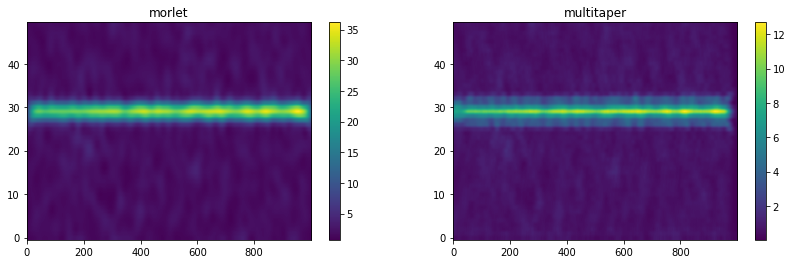

In [8]:
plt.figure(figsize=(14,4))
for i, mode in enumerate(["morlet", "multitaper"]):
    out = _tf_decomp(x, sfreq, freqs, mode=mode,
                     n_cycles=n_cycles, n_jobs=1)
    S = (out * np.conj(out)).real
    plt.subplot(1,2,i+1)
    plt.imshow(S.mean(0)[0], aspect="auto", origin="lower")
    plt.title(mode)
    plt.colorbar()
    print( S.mean(axis=(0,-1))[:, np.logical_and(freqs>=28, freqs<=32)].mean(1) )

#### Non-stationary sinusoidal signal

In [9]:
sfreq = 200.
N = 1000
t = np.arange(0, N//sfreq, 1/sfreq)
x = np.sin(2*np.pi*t*10)*(t<2.5) + np.sin(2*np.pi*t*30)*(t>=2.5)\
    + np.random.normal(0, 1, size=(n_epochs, n_roi, n_times))

[10.93806746 10.81683968 11.17574349 11.04358754]
[11.55124923 11.06386807 11.27463692 11.25522778]
[3.18151441 3.14260503 3.25288155 3.20344482]
[3.45355903 3.3023615  3.3623529  3.36227178]


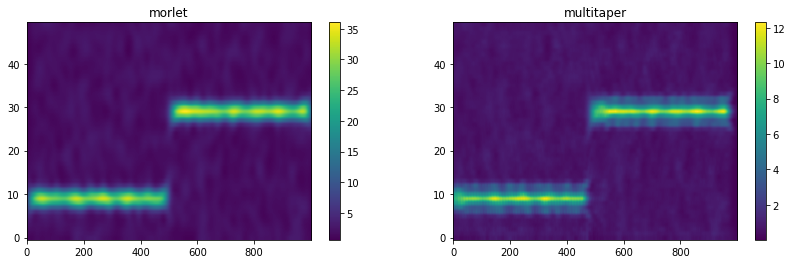

In [10]:
plt.figure(figsize=(14,4))
for i, mode in enumerate(["morlet", "multitaper"]):
    out = _tf_decomp(x, sfreq, freqs, mode=mode,
                     n_cycles=n_cycles, n_jobs=1)
    S = (out * np.conj(out)).real
    plt.subplot(1,2,i+1)
    plt.imshow(S.mean(0)[0], aspect="auto", origin="lower")
    plt.title(mode)
    plt.colorbar()
    print( S.mean(axis=(0,-1))[:, np.logical_and(freqs>=8, freqs<=12)].mean(1) )
    print( S.mean(axis=(0,-1))[:, np.logical_and(freqs>=28, freqs<=32)].mean(1) )

### Comparisons for conn_spec

#### Stationary sinusoidal signal

In [11]:
sfreq, freqs = 200, np.arange(1, 51, 1)
N = 1000
t = np.arange(0, N//sfreq, 1/sfreq)
n_roi, n_times, n_epochs = 4, 1000, 20
x = np.sin(2*np.pi*t*30)\
    + np.random.normal(0, 1, size=(n_epochs, n_roi, n_times))

In [12]:
n_cycles = freqs/2

In [13]:
data = xr.DataArray(x, dims=("trials", "roi", "times"),
                    coords={"times": t})

[0.8109516  0.8105087  0.82020265 0.807872   0.80613136 0.8079866 ]
[0.84277534 0.8438079  0.846522   0.84422654 0.84326345 0.8432307 ]


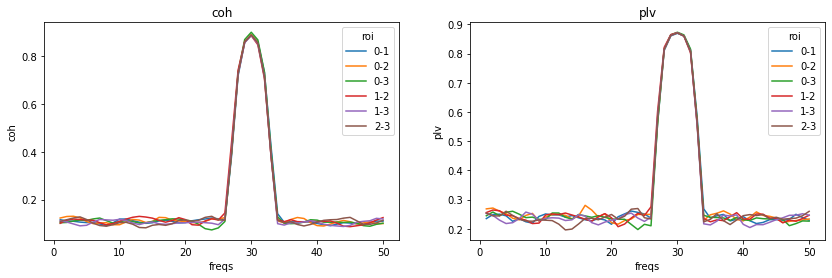

In [14]:
plt.figure(figsize=(14,4))
for i, metric in enumerate(["coh", "plv"]):
    out = conn_spec(data, sfreq=sfreq, metric=metric, freqs=freqs, verbose=False,
                    sm_times=2, sm_kernel='square', n_jobs=1, n_cycles=n_cycles,
                    times="times", roi="roi")
    plt.subplot(1,2,i+1)
    out.mean(dim=("trials","times")).plot(x="freqs", hue="roi");
    plt.title(metric)
    actual = out.mean(dim=("trials","times")).sel(freqs=slice(28,32)).mean("freqs")
    print(actual.data)

#### Non-stationary sinusoidal signal

In [15]:
sfreq = 200.
N = 1000
t = np.arange(0, N//sfreq, 1/sfreq)
x = np.sin(2*np.pi*t*10)*(t<2.5) + np.sin(2*np.pi*t*30)*(t>=2.5)\
    + np.random.normal(0, 1, size=(n_epochs, n_roi, n_times))

In [16]:
data = xr.DataArray(x, dims=("trials", "roi", "times"),
                    coords={"times": t})

[0.5848008  0.5820761  0.57519233 0.57582587 0.5878697  0.5844447 ]
[0.6797098  0.68089503 0.67178345 0.6808964  0.68503004 0.6821357 ]


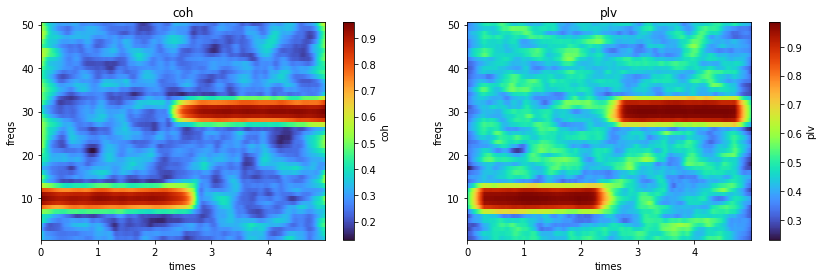

In [17]:
plt.figure(figsize=(14,4))
for i, metric in enumerate(["coh", "plv"]):
    out = conn_spec(data, sfreq=sfreq, metric=metric, freqs=freqs, verbose=False,
                    sm_times=.6, sm_kernel='square', n_jobs=1, n_cycles=n_cycles,
                    times="times", roi="roi")
    plt.subplot(1,2,i+1)
    out.mean("trials").isel(roi=0).plot.imshow(x="times", y="freqs", cmap="turbo")
    plt.title(metric)
    actual = out.mean(dim=("trials","times")).sel(freqs=slice(28,32)).mean("freqs")
    print(actual.data)